In [1]:
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
import random
import tensorflow

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.python.keras import backend as k
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
#from tensorflow import set_random_seed
tensorflow.random.set_seed(123)

#set_random_seed(123)
random.seed(123)

In [3]:
os.chdir('C:\\Users\\Vipul k Dhiman\\Desktop')
os.getcwd()

'C:\\Users\\Vipul k Dhiman\\Desktop'

In [5]:
train = pd.read_csv('sentiment_train.tsv', sep = '\t', low_memory = False)
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [6]:
train.shape

(156060, 4)

In [7]:
train = DataFrame.drop_duplicates(train) #Remove Duplicates

In [8]:
train.isnull().sum() #Missing value check

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [9]:
## EDA
# Let's use groupby to use describe by label
train.groupby('Sentiment').describe()

PhraseId                                                        \
             count          mean           std    min       25%      50%   
Sentiment                                                                  
0           7072.0  81035.048784  43705.802913  102.0  44891.00  81796.0   
1          27273.0  80495.252447  45125.763868    1.0  41566.00  81334.0   
2          79582.0  76527.962441  45351.766531    2.0  36798.00  76188.5   
3          32927.0  78409.828378  44596.812258   22.0  40094.00  78068.0   
4           9206.0  80052.598197  44310.325650   64.0  42766.75  80185.0   

                              SentenceId                                 \
                75%       max      count         mean          std  min   
Sentiment                                                                 
0          117412.0  155974.0     7072.0  4241.946126  2434.936265  3.0   
1          119969.0  156057.0    27273.0  4216.860265  2510.922820  1.0   
2          115680.5  156060.0    79582.0  3997.699090  2516.081021  1.0   
3          117275.5  156058.0    32927.0  4098.831597  2480.081070  1.0   
4          118439.0  156011.0     9206.0  4189.713448  2466.092532  2.0   

                                             
               25%     50%      75%     max  
Sentiment                                    
0          2177.00  4221.0  6265.25  8539.0  
1          2001.00  4192.0  6416.00  8544.0  
2          1743.25  3909.0  6164.00  8544.0  
3          1919.00  4018.0  6257.00  8544.0  
4          2064.25  4131.0  6327.75  8541.0

In [10]:
# Apply & adding the length column
train['length'] = train['Phrase'].apply(len).copy()
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,length
0,1,1,A series of escapades demonstrating the adage ...,1,188
1,2,1,A series of escapades demonstrating the adage ...,2,77
2,3,1,A series,2,8
3,4,1,A,2,1
4,5,1,series,2,6


count    156060.000000
mean         40.217224
std          38.154130
min           1.000000
25%          14.000000
50%          26.000000
75%          53.000000
max         283.000000
Name: length, dtype: float64

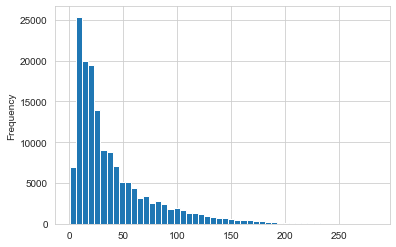

In [11]:
# Visualization
train['length'].plot(bins=50, kind='hist') # Univariate
train.length.describe()

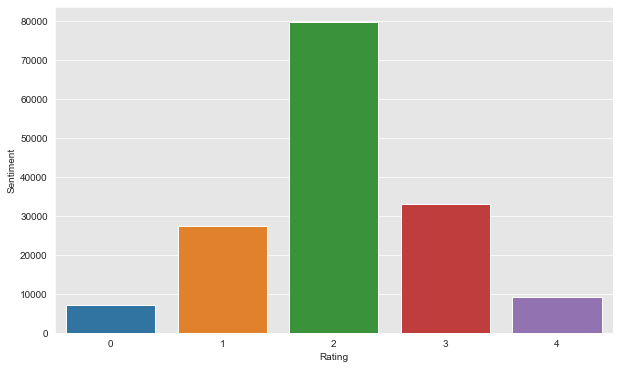

In [12]:
a = train.Sentiment.value_counts()
a = pd.DataFrame(a)
a['Rating'] = a.index
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(y='Sentiment', x='Rating', data=a)

In [13]:
train[train['length'] == 283]['Phrase'].iloc[0] #Extracting the lengthiest text(283)

"... spiced with humor -LRB- ' I speak fluent flatula , ' advises Denlopp after a rather , er , bubbly exchange with an alien deckhand -RRB- and witty updatings -LRB- Silver 's parrot has been replaced with Morph , a cute alien creature who mimics everyone and everything around -RRB-"

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B73E79DB88>,
      dtype=object)

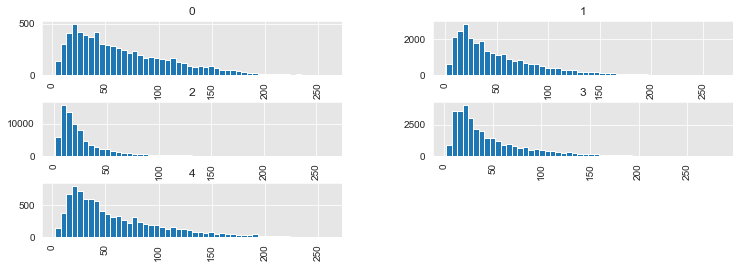

In [14]:
# let's see if message length is a distinguishing feature between the sentiment
train.hist(column='length', by='Sentiment', bins=50,figsize=(12,4))

In [15]:
# Cleaning Function
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

In [18]:
nltk.download('punkt')
nltk.download('wordnet')

train_sentences = clean_sentences(train)
print(len(train_sentences))

[nltk_data] Downloading package punkt to C:\Users\Vipul k
[nltk_data]     Dhiman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Vipul k
[nltk_data]     Dhiman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|████████████████████████████████████████████████████████████████████████| 156060/156060 [02:00<00:00, 1300.46it/s]


156060


In [19]:
target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

In [20]:
# Data Bifurcation
X_train,X_val,y_train,y_val=train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

In [21]:
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)

100%|██████████████████████████████████████████████████████████████████████| 124848/124848 [00:00<00:00, 675286.79it/s]


In [22]:
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

13740
48


In [23]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

In [24]:
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

In [25]:
X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)

In [26]:
print(X_train.shape,X_val.shape)

(124848, 48) (31212, 48)


In [27]:
# Early Stopping
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

In [28]:
# Model Building
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 300)           4122000   
_________________________________________________________________
lstm (LSTM)                  (None, 48, 128)           219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 4,398,061
Trainable params: 4,398,061
Non-trainable params: 0
______________________________________________

In [29]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=5, batch_size=256, verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/5
124848/124848 [==============================] - 257s 2ms/sample - loss: 1.0131 - accuracy: 0.5914 - val_loss: 0.8496 - val_accuracy: 0.6523
Epoch 2/5
124848/124848 [==============================] - 247s 2ms/sample - loss: 0.8166 - accuracy: 0.6640 - val_loss: 0.8204 - val_accuracy: 0.6611
Epoch 3/5
124848/124848 [==============================] - 272s 2ms/sample - loss: 0.7523 - accuracy: 0.6883 - val_loss: 0.8120 - val_accuracy: 0.6679
Epoch 4/5
124848/124848 [==============================] - 284s 2ms/sample - loss: 0.7164 - accuracy: 0.7028 - val_loss: 0.8140 - val_accuracy: 0.6712
Epoch 5/5
124848/124848 [==============================] - 289s 2ms/sample - loss: 0.6927 - accuracy: 0.7120 - val_loss: 0.8216 - val_accuracy: 0.6687


In [30]:
epoch_count = range(1, len(history.history['loss']) + 1)

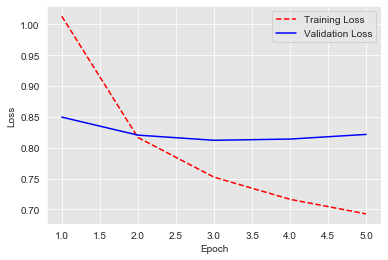

In [31]:
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()